# Notebook for plotting and fitting nucleosome sliding kinetics

This script was used to generate data in Nodelman et al., 2025 NSMB. It reads in a single csv file and plots data in a bar graph.

The expected format of the csv file is one construct per row, with the construct name first, followed by values from different replicates. Data can be separated by multiple commas, which allows experiments to be organized by the days they were carried out (OK to have empty cells/multiple commas without data between every one). Note that the first line is ignored (used for naming experimental datasets. Example data (used for paper) is Nodelman2025NSMB-TwistDefectEntry-Rand2-2024Aug12a.csv

To run this on your computer, you must give the correct paths/directories for the data and output. These are labeled ###Edit this ### in the block 'Edit this block - define data filename and directories' 

This script was made to run with python 3.8.8 (conda install) and jupyter with the following module versions:

jupyter core     : 4.7.1

jupyter-notebook : 6.3.0

qtconsole        : 5.0.3

ipython          : 7.22.0

ipykernel        : 5.3.4

jupyter client   : 6.1.12

jupyter lab      : 3.0.14

nbconvert        : 6.0.7

ipywidgets       : 7.6.3

nbformat         : 5.1.3

traitlets        : 5.0.5

In [2]:
%matplotlib inline
from __future__ import division
import matplotlib
#import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import sys
import time
from pylab import *
import statistics
import math
import re
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import scipy.optimize as opt
from scipy.optimize import curve_fit

matplotlib.rcParams['font.sans-serif']='Arial'
matplotlib.rcParams.update({'font.size': 24, "axes.formatter.limits": (-4,4)})
plotStyles={"markersize":12,"markeredgewidth":3.0,"linewidth":3.0}


colorlist=["black","red","orange","darkgray","green","dodgerblue","darkviolet","gray","brown","chocolate","blue",
          "hotpink","darkkhaki","darkgoldenrod","cyan","deepskyblue","mediumpurple","red","orange","brown","green",
           "dodgerblue","darkviolet","red","orange","darkgray","green","dodgerblue","darkviolet","gray","brown","orange","chocolate","blue",
          "hotpink","darkkhaki","darkgoldenrod","cyan","deepskyblue","mediumpurple","red","orange","brown","green","dodgerblue","darkviolet"]

## rate equations

In [3]:
def fitsingleexp(t,k,Amp,c):
    '''
    This fits for a single exponential rate, as well as an amplitude (Amp) and constant c
    t is time (x-values)
    Be sure to have all three values (k, Amp, c) in the initial_guesses array.
    '''
    y = Amp*np.exp(-1*k*t) + c
    return(y)

def fitsingleexprise(t,k,Amp,c):
    '''
    This fits for a single exponential rate, as well as an amplitude (Amp) and constant c
    t is time (x-values)
    Be sure to have all three values (k, Amp, c) in the initial_guesses array.
    '''
    y =(1-Amp*np.exp(-1*k*t) + c)
    return(y)

def fitsingleexprise80(t,k,c):
    '''
    This fits for a single exponential rate, as well as an amplitude (Amp) and constant c
    t is time (x-values)
    Be sure to have all three values (k, Amp, c) in the initial_guesses array.
    '''
    Amp = 0.80
    y =(1-Amp*np.exp(-1*k*t) + c)
    return(y)

def fitsingleexprise2(t,k,Amp):
    '''
    This fits for a single exponential rate, as well as an amplitude (Amp) and constant c
    t is time (x-values)
    Be sure to have all three values (k, Amp, c) in the initial_guesses array.
    '''
    y =(1-Amp*np.exp(-1*k*t))
    return(y)

def fitdoubleexprise(t,k1,Amp1,k2,Amp2,c):
    '''
    This fits for a single exponential rate, as well as an amplitude (Amp) and constant c
    t is time (x-values)
    Be sure to have all three values (k, Amp, c) in the initial_guesses array.
    '''
    y =(1-(Amp1*np.exp(-1*k1*t)+Amp2*np.exp(-1*k2*t)) + c)
    return(y)

def fitlinear(t,m,b):
    '''
    y = mx+b
    '''
    y = m*t + b
    return(y)

## defs

In [4]:
def gettimestamp():
    '''
    returns a string of the current day-hour-min
    be sure to import time in preamble
    '''
    if time.localtime().tm_min < 10:
        currenttimestamp=str(time.localtime().tm_year)+"_"+str(time.localtime().tm_mon)+"_"+str(time.localtime().tm_mday)+"-"+str(time.localtime().tm_hour)+"0"+str(time.localtime().tm_min)
    else:
        currenttimestamp=str(time.localtime().tm_year)+"_"+str(time.localtime().tm_mon)+"_"+str(time.localtime().tm_mday)+"-"+str(time.localtime().tm_hour)+str(time.localtime().tm_min)
    return(currenttimestamp)

def extractdatacolumn(tempfilename, datacolumn):
    '''read a file and output a list, here assuming all are floats
    datacolumn input indicates what column to extract
    '''
    tempfile=open(tempfilename,"r")
    datalist=[]
    tempfilelist=tempfile.readlines()
    for line in tempfilelist:
        temp=line.split()
        datalist.append(float(temp[datacolumn]))
    return datalist

def extractdatacolumncsv(tempfilename, datacolumn):
    '''read a file and output a list, here assuming all are floats
    datacolumn input indicates what column to extract
    '''
    #print("###### extractdatacolumncsv ######")
    tempfile=open(tempfilename,"r")
    datalist=[]
    tempfilelist=tempfile.readlines()
    for line in tempfilelist:
        #print(line,"line")
        line.strip()
        if "," in line:
            temp=line.split(",")
            #print(temp)
            for i in range(len(temp)):
                if '\ufeff' in temp[i]:
                    temp[i]="0"+temp[i][6:]
            datalist.append(float(temp[datacolumn]))
    return datalist

In [5]:
def plot_datafolders_all(inputdict,dictfolderlist,workingname,plotparam={},parameterdict={}):
    '''
    plot the averages and individual data for the specified folders, along with fits and error bars
    '''

    ### get or set the parameters for the plots
    if 'update' not in parameterdict:
        parameterdict['update']={'font.size': 10, "axes.formatter.limits": (-4,4),'errorbar.capsize': 2}
    
    parameterdict['update']["figure.figsize"]=12,2*5*len(dictfolderlist)
    print("length of dictfolderlist = {}".format(len(dictfolderlist)))
    print("dictfolderlist = {}".format(dictfolderlist))          
    
    if 'plotStyles1' not in parameterdict:
        parameterdict['plotStyles1']={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}

    if 'plotStyles2' not in parameterdict:
        parameterdict['plotStyles2']={"markersize":12,'alpha':0.5}

    mpl.rcParams.update(parameterdict['update'])
    print("Using these parameters:")
    for item in parameterdict['update']:
        print(item,parameterdict['update'][item])
    print()
    ### here assuming that each folder has a 'xvaluesAVG' list; using largest number for calculating fitting range
    if "fitxvalues" not in plotparam:
        plotparam["fitxvalues"]=np.arange(inputdict[dictfolderlist[0]]['xvaluesAVG'][-1])
    fitxvalues = plotparam["fitxvalues"]
    
    fig, axs = plt.subplots(2*len(dictfolderlist), 1)

    ### note - cannot use i for both the numbering of subfigures and the
    #dirkeyindices
    for i in range(len(dictfolderlist)):
        if inputdict[dictfolderlist[i]]["fittingmodel"] == "1site":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, calc1_Kd(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM".format(inputdict[dictfolderlist[i]]["fitAVG"][0]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, calc1_Kd(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd ={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0]),color=colorlist[j])
                ##axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                axs[i*2].legend()
        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddouble":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, calcKddouble(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]]["fitAVG"][0],inputdict[dictfolderlist[i]]["fitAVG"][1]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, calcKddouble(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                #axs[i*2].legend()
                
        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddoubleAmp":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]]["fitAVG"][0],inputdict[dictfolderlist[i]]["fitAVG"][1]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                #axs[i*2].legend()

        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddoubleAmpFixed":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]]["fitAVG"][0],inputdict[dictfolderlist[i]]["fitAVG"][1]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                #axs[i*2].legend()
        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "fitsingleexprise":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, fitsingleexprise(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="k ={:6.3f}+/-{:6.3f} min-1".format(inputdict[dictfolderlist[i]]["fitAVG"][0],inputdict[dictfolderlist[i]]['fitSTDEV'][0]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, fitsingleexprise(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="k={:6.3f} min-1".format(inputdict[dictfolderlist[i]][j]["fit"][0]),color=colorlist[j])
                #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                #axs[i*2].legend()

        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "fitsingleexprise80":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, fitsingleexprise80(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="k ={:6.3f}+/-{:6.3f} min-1".format(inputdict[dictfolderlist[i]]["fitAVG"][0],inputdict[dictfolderlist[i]]['fitSTDEV'][0]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, fitsingleexprise80(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="k={:6.3f} min-1".format(inputdict[dictfolderlist[i]][j]["fit"][0]),color=colorlist[j])
                #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                #axs[i*2].legend()

    ### add this to make it a log plot
    #plt.semilogx()
    ### if a log plot, change the lower bounds for xlim and ylim below
    ##plt.xlim([1, 5500])
    #plt.ylim([0.01, 1.1])

    loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals

    ### here pass on plot parameters via plotparam dictionary; otherwise, use these defaults:
    if "xlabel" not in plotparam:
        plotparam["xlabel"]='[Chd1] (nM)'
    if "ylabel" not in plotparam:
        plotparam["ylabel"]='fraction bound'
    if "xlim" not in plotparam:
        plotparam["xlim"]=[1, 5500]
    if "ylim" not in plotparam:
        plotparam["ylim"]=[0.01, 1.1]
    if "legend_loc" not in plotparam:
        plotparam["legend_loc"]='center left'
    if "legend_bbox_to_anchor" not in plotparam:
        plotparam["legend_bbox_to_anchor"]=(1, 0.5)
        
    for ax in axs.flat:
        ax.semilogx()
        ax.set(xlabel=plotparam["xlabel"], ylabel=plotparam["ylabel"])
        #ax.set(xlim=[-15, 5000],ylim=[0, 1.1])
        ax.set(xlim=plotparam["xlim"],ylim= plotparam["ylim"])
        #ax.xaxis.set_major_locator(loc)
        ax.legend(loc=plotparam["legend_loc"], bbox_to_anchor=plotparam["legend_bbox_to_anchor"])

    
    fig.tight_layout(h_pad=2)

    #add time stamp to filename
    outputname=workingname+"_"+gettimestamp()+".pdf"

    #uncomment to save plot as a PDF
    fig.savefig(outputname,format='pdf', bbox_inches='tight')
    #fig.savefig(outputname,format='pdf',dpi=300, bbox_inches='tight')

    return

def plot_datafolders_indiv_together(inputdict,dictfolderlist,workingname,plotparam={},parameterdict={}):
    '''
    plot the averages and individual data for the specified folders, along with fits and error bars
    '''

    ### get or set the parameters for the plots
    if 'update' not in parameterdict:
        parameterdict['update']={'font.size': 10, "axes.formatter.limits": (-4,4),'errorbar.capsize': 2}
    
    if "figure.figsize" not in parameterdict['update']:
        parameterdict['update']["figure.figsize"]=12,5*len(dictfolderlist)
    
    if 'plotStyles1' not in parameterdict:
        parameterdict['plotStyles1']={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}

    if 'plotStyles2' not in parameterdict:
        parameterdict['plotStyles2']={"markersize":12,'alpha':0.5}

    mpl.rcParams.update(parameterdict['update'])
    
    ### here assuming that each folder has a 'xvaluesAVG' list; using largest number for calculating fitting range
    if "fitxvalues" not in plotparam:
        plotparam["fitxvalues"]=np.arange(inputdict[dictfolderlist[0]]['xvaluesAVG'][-1])
    fitxvalues = plotparam["fitxvalues"]

    fig, axs = plt.subplots(len(dictfolderlist), 1)

    ### note - cannot use i for both the numbering of subfigures and the
    #dirkeyindices
    for i in range(len(dictfolderlist)):
        if inputdict[dictfolderlist[i]]["fittingmodel"] == "1site":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i].plot(fitxvalues, calc1_Kd(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd ={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0]),color=colorlist[j])
                axs[i].legend()
        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddouble":
            #axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i].plot(fitxvalues, calcKddouble(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i*2].legend()

        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddoubleAmp":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i*2].legend()

        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "fitsingleexprise":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i].plot(fitxvalues, fitsingleexprise(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="k={:6.3f} min-1".format(inputdict[dictfolderlist[i]][j]["fit"][0]),color=colorlist[j])
                #axs[i*2].legend()

    ### add this to make it a log plot
    #plt.semilogx()
    ### if a log plot, change the lower bounds for xlim and ylim below
    ##plt.xlim([1, 5500])
    #plt.ylim([0.01, 1.1])

    loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals

    if "xlabel" not in plotparam:
        plotparam["xlabel"]='[Chd1] (nM)'
    if "ylabel" not in plotparam:
        plotparam["ylabel"]='fraction bound'
    if "xlim" not in plotparam:
        plotparam["xlim"]=[1, 5500]
    if "ylim" not in plotparam:
        plotparam["ylim"]=[0.01, 1.1]
    if "legend_loc" not in plotparam:
        plotparam["legend_loc"]='center left'
    if "legend_bbox_to_anchor" not in plotparam:
        plotparam["legend_bbox_to_anchor"]=(1, 0.5)
        
    for ax in axs.flat:
        ax.semilogx()
        ax.set(xlabel=plotparam["xlabel"], ylabel=plotparam["ylabel"])
        #ax.set(xlim=[-15, 5000],ylim=[0, 1.1])
        ax.set(xlim=plotparam["xlim"],ylim= plotparam["ylim"])
        #ax.xaxis.set_major_locator(loc)
        ax.legend(loc=plotparam["legend_loc"], bbox_to_anchor=plotparam["legend_bbox_to_anchor"])

    
    fig.tight_layout(h_pad=2)

    #add time stamp to filename
    outputname=workingname+"_"+gettimestamp()+".pdf"

    #uncomment to save plot as a PDF
    fig.savefig(outputname,format='pdf', bbox_inches='tight')
    #fig.savefig(outputname,format='pdf',dpi=300, bbox_inches='tight')

    return

def plot_datafolders_indiv_separate(inputdict,dictfolderlist,workingname,plotparam={},parameterdict={}):
    '''
    plot the averages and individual data for the specified folders, along with fits and error bars
    '''

    ### get or set the parameters for the plots
    if 'update' not in parameterdict:
        parameterdict['update']={'font.size': 10, "axes.formatter.limits": (-4,4),'errorbar.capsize': 2}
    
    if "figure.figsize" not in parameterdict['update']:
        parameterdict['update']["figure.figsize"]=12,5*len(dictfolderlist)
    
    if 'plotStyles1' not in parameterdict:
        parameterdict['plotStyles1']={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}

    if 'plotStyles2' not in parameterdict:
        parameterdict['plotStyles2']={"markersize":12,'alpha':0.5}
   
    ### here assuming that each folder has a 'xvaluesAVG' list; using largest number for calculating fitting range
    if "fitxvalues" not in plotparam:
        plotparam["fitxvalues"]=np.arange(inputdict[dictfolderlist[0]]['xvaluesAVG'][-1])
    fitxvalues = plotparam["fitxvalues"]
    
    ### calculate number of subplots...
    subplotmap=[]
    
    for folder in dictfolderlist:
        for expt in inputdict[folder]["filekeyindices"]:
            subplotmap.append([folder,expt])
    
    parameterdict['update']["figure.figsize"]=12,5*len(subplotmap)

    mpl.rcParams.update(parameterdict['update'])

    fig, axs = plt.subplots(len(subplotmap), 1)

    ### note - cannot use i for both the numbering of subfigures and the
    #dirkeyindices
    for i in range(len(subplotmap)):
        if inputdict[subplotmap[i][0]]["fittingmodel"] == "1site":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, calc1_Kd(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="Kd ={:6.1f} nM".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0]),color=colorlist[i])
            axs[i].legend()
        elif inputdict[subplotmap[i][0]]["fittingmodel"] == "calcKddouble":
            #axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, calcKddouble(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0],inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][1]),color=colorlist[i])
            #axs[i*2].legend()

        elif inputdict[subplotmap[i][0]]["fittingmodel"] == "calcKddoubleAmp":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0],inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][1]),color=colorlist[i])
            #axs[i*2].legend()

        elif inputdict[subplotmap[i][0]]["fittingmodel"] == "calcKddoubleAmpFixed":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0],inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][1]),color=colorlist[i])
            #axs[i*2].legend()

        elif inputdict[subplotmap[i][0]]["fittingmodel"] == "fitsingleexprise":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, fitsingleexprise(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="k={:6.3f} min-1".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0]),color=colorlist[i])
            #axs[i*2].legend()


    ### add this to make it a log plot
    #plt.semilogx()
    ### if a log plot, change the lower bounds for xlim and ylim below
    ##plt.xlim([1, 5500])
    #plt.ylim([0.01, 1.1])

    loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals

    if "xlabel" not in plotparam:
        plotparam["xlabel"]='[Chd1] (nM)'
    if "ylabel" not in plotparam:
        plotparam["ylabel"]='fraction bound'
    if "xlim" not in plotparam:
        plotparam["xlim"]=[1, 5500]
    if "ylim" not in plotparam:
        plotparam["ylim"]=[0.01, 1.1]
    if "legend_loc" not in plotparam:
        plotparam["legend_loc"]='center left'
    if "legend_bbox_to_anchor" not in plotparam:
        plotparam["legend_bbox_to_anchor"]=(1, 0.5)
        
    for ax in axs.flat:
        ax.semilogx()
        ax.set(xlabel=plotparam["xlabel"], ylabel=plotparam["ylabel"])
        #ax.set(xlim=[-15, 5000],ylim=[0, 1.1])
        ax.set(xlim=plotparam["xlim"],ylim= plotparam["ylim"])
        #ax.xaxis.set_major_locator(loc)
        ax.legend(loc=plotparam["legend_loc"], bbox_to_anchor=plotparam["legend_bbox_to_anchor"])

    
    fig.tight_layout(h_pad=2)

    #add time stamp to filename
    outputname=workingname+"_"+gettimestamp()+".pdf"

    #uncomment to save plot as a PDF
    fig.savefig(outputname,format='pdf', bbox_inches='tight')
    #fig.savefig(outputname,format='pdf',dpi=300, bbox_inches='tight')

    return


# Edit this block - define data filename and directories

In [8]:
### Edit this ###
pathtocsvdirectory="/Users/gbowman3/tempdata/nativegelsliding-csvfiles/"
outputdirectory="/Users/gbowman3/temp/"

### create output directory if it doesn't already exist
try:
    os.listdir(outputdirectory)
except FileNotFoundError:
    os.mkdir(outputdirectory)
    print("created new directory for output files:\n{}\n\n".format(outputdirectory))

In [47]:
### Put the path for each directory to be analyzed; for each directory, do not have spaces in the foldername;
###     The data in each folder will automatically be averaged together, so be sure that these datasets go together;
###     Each foldername will be used as the name for that group of files.

### Edit this ###
# names of each folder holding csv data
directoriestoanalyze=[
    pathtocsvdirectory+"120Bwt/",
    pathtocsvdirectory+"SAIL/",
    pathtocsvdirectory+"SAILLobe2/",
    pathtocsvdirectory+"876881/",
    pathtocsvdirectory+"M876N/",
    pathtocsvdirectory+"F877N/",
    pathtocsvdirectory+"884889/",
    pathtocsvdirectory+"FLF/",
    pathtocsvdirectory+"I583N/",
    pathtocsvdirectory+"I838N/",
    pathtocsvdirectory+"A842N/",
    pathtocsvdirectory+"Y841A/",
    pathtocsvdirectory+"I843Nonly/",
    pathtocsvdirectory+"884889-I843N/",
    pathtocsvdirectory+"Y926Nonly/",
    pathtocsvdirectory+"W932Aonly/",
    pathtocsvdirectory+"884889-W932A/",
    pathtocsvdirectory+"884889-Y926N/",
    pathtocsvdirectory+"M652Q/",
    pathtocsvdirectory+"H587D/",
    pathtocsvdirectory+"L865N-L869N/"
    
]

masterdictionary={}
masterdictionary["dirkeys"]=[]

### here give all of the directories to go into

dirkeyindices=[] #list that holds keys for top-level dictionary

for i in range(len(directoriestoanalyze)):
    masterdictionary[i]={}
    masterdictionary[i]["fullpath"]=directoriestoanalyze[i]
    dirsplit=directoriestoanalyze[i].split("/")
    masterdictionary[i]["dataname"]=dirsplit[-2].strip()
    masterdictionary[i]["dirname"]=dirsplit[-2].strip()
    masterdictionary[i]["xyvalues-all"]={} #this will hold all y-values as lists according to x-value
    masterdictionary[i]["xvaluesAVG"]=[] # will fill once read and average together data
    masterdictionary[i]["yvaluesAVG"]=[]
    masterdictionary[i]["yvaluesSTDEV"]=[]
    masterdictionary[i]["fitvalues"]=[]
    masterdictionary[i]["fitAVG"]=[]
    masterdictionary[i]["fitSTDEV"]=[]
    masterdictionary[i]["color0"]="black"
    masterdictionary[i]["color1"]=colorlist[i]
    masterdictionary[i]["color2"]=colorlist[i]
    masterdictionary[i]["filekeyindices"]=[] # this will hold the integers to call individual files
    dirkeyindices.append(i) # these will be in order, so don't need sorting
    #
    masterdictionary[i]["fittingmodel"]="fitsingleexprise"
    masterdictionary[i]["fitguess"]=np.array([0.8,0.9,0.1])

    # now go into each directory in directoriestoanalyze list and read all files
    
    try:
        alldirectorylisttemp=os.listdir(directoriestoanalyze[i])
        datadirectorylist=[]
        print("reading files in folder:\n\t",directoriestoanalyze[i])
        print()
        print("here only looking at \".csv\" files:")
        for datafile in alldirectorylisttemp:
            if datafile[-3:]=="csv":
                print("\t\t"+datafile)
                datadirectorylist.append(datafile)
        print()
        datadirectorylist.sort()
    except FileNotFoundError:
        print("#"*60,"\n","#"*60)
        print("#"*10,"WARNING: unable to open this directory:","#"*10)
        print("\t{}".format(directoriestoanalyze[i]))
        print("\n")
        print("Please go back and be sure that this directory exists and contains csv files.\n")
        print("#"*60,"\n","#"*60)
        sys.exit("EXITING...")

    ### make a sub-dictionary for each csv file, with the number of the dataset being the key; 
    ### convert string to int; 
    #   xlist and ylist are lists of the first and second items on each line in the file
    #   dataname is the original filename

    print("x-values for each dataset:")
    for j in range(len(datadirectorylist)):
        masterdictionary[i][j]={}
        filename=datadirectorylist[j]
        masterdictionary[i][j]["filename"]=filename
        masterdictionary[i][j]["othername"]=filename
        masterdictionary[i][j]["filenumber"]=j
        masterdictionary[i][j]["xvalues"]=extractdatacolumncsv(directoriestoanalyze[i]+filename,0)
        masterdictionary[i][j]["yvalues"]=extractdatacolumncsv(directoriestoanalyze[i]+filename,1)
        masterdictionary[i]["filekeyindices"].append(int(j))
        if len(masterdictionary[i][j]["xvalues"]) != len(masterdictionary[i][j]["yvalues"]):
            print("#"*60,"\n")
            print("WARNING - the x- and y-values do not match up!")
            print(masterdictionary[i][j]["filename"])
            print(" in folder")
            print(directoriestoanalyze[i])
            print("#"*60,"\n")
            sys.exit()
        print(j, masterdictionary[i][j]["xvalues"])
        for k in range(0,len(masterdictionary[i][j]["xvalues"])):
            if masterdictionary[i][j]["xvalues"][k] in masterdictionary[i]["xyvalues-all"]:
                # key already exists, then just add to the list that should be there
                masterdictionary[i]["xyvalues-all"][masterdictionary[i][j]["xvalues"][k]].append(masterdictionary[i][j]["yvalues"][k])
            else:
                # new key in the dictionary with a 1-item list (the y-value) as the value
                masterdictionary[i]["xyvalues-all"][masterdictionary[i][j]["xvalues"][k]]=[masterdictionary[i][j]["yvalues"][k]]
    #calculate the average y-values for each x-value
    masterdictionary[i]["xvaluesAVG"]=list(masterdictionary[i]["xyvalues-all"].keys())
    print("master xvalues:")
    print("*",masterdictionary[i]["xvaluesAVG"])
    if len(masterdictionary[i]["filekeyindices"])>1:
        for key in masterdictionary[i]["xyvalues-all"].keys():
            if len(masterdictionary[i]["xyvalues-all"][key])>1:
                masterdictionary[i]["yvaluesAVG"].append(statistics.mean(masterdictionary[i]["xyvalues-all"][key]))
                masterdictionary[i]["yvaluesSTDEV"].append(statistics.stdev(masterdictionary[i]["xyvalues-all"][key]))
            elif len(masterdictionary[i]["xyvalues-all"][key])==1:
                masterdictionary[i]["yvaluesAVG"].append(masterdictionary[i]["xyvalues-all"][key][0])
                masterdictionary[i]["yvaluesSTDEV"].append(0)

    else:
        for key in masterdictionary[i]["xyvalues-all"].keys():
            masterdictionary[i]["yvaluesAVG"].append(masterdictionary[i]["xyvalues-all"][key])
            masterdictionary[i]["yvaluesSTDEV"].append(0)

    print()
print()

print("#"*60,"\n")
print("These folders and datafiles that have been read in:")
for dirnumber in dirkeyindices:
    print(dirnumber,masterdictionary[dirnumber]["dirname"])
    for filenumber in masterdictionary[dirnumber]["filekeyindices"]:
        print("\t",filenumber,masterdictionary[dirnumber][filenumber]["filename"])
    print()
    if len(masterdictionary[dirnumber].keys())<12:
        print("#"*60)
        print("#"*60)
        print("\t WARNING: this directory does not have csv files:")
        print(masterdictionary[dirnumber]["fullpath"])
        print("#"*60)
        print("#"*60)
        print()
        print("Please either put csv files in that directory, or remove from the dir list")
        sys.exit("EXITING...")

masterdictionary["dirkeys"]=list(dirkeyindices)


reading files in folder:
	 /Users/gbowman3/tempdata/nativegelsliding-csvfiles/120Bwt/

here only looking at ".csv" files:
		Chd1sliding120Bwt-super-80601n0-2024May16a.csv
		Chd1sliding120Bwt-super-80601n0-2024May16b.csv
		Chd1sliding120Bwt-super-80601n0-2024Apr16b.csv
		Chd1sliding120Bwt-super-80601n0-2024May27a.csv
		Chd1sliding120Bwt-super-80601n0-2024Apr16a.csv
		Chd1sliding120Bwt-super-80601n0-2024May30a.csv
		Chd1sliding120Bwt-super-80601n0-2024May24a.csv
		Chd1sliding120Bwt-super-80601n0-2024Jun11a.csv
		Chd1sliding120Bwt-super-80601n0-2024May15b.csv
		Chd1sliding120Bwt-super-80601n0-2024May23a.csv
		Chd1sliding120Bwt-super-80601n0-2024May15a.csv

x-values for each dataset:
0 [0.0, 0.066666667, 0.133333333, 0.2, 0.266666667, 0.333333333, 0.5, 0.7, 1.0, 2.0, 4.0, 8.0, 16.0]
1 [0.0, 0.066666667, 0.133333333, 0.2, 0.266666667, 0.333333333, 0.5, 0.7, 1.0, 2.0, 4.0, 8.0, 16.0]
2 [0.0, 0.066666667, 0.133333333, 0.2, 0.266666667, 0.333333333, 0.5, 0.7, 1.0, 2.0, 4.0, 8.0, 16.0]
3 [0.0, 

In [35]:
#fit all with normal singleexprise
for i in dirkeyindices:
    masterdictionary[i]["fittingmodel"]="fitsingleexprise"
    masterdictionary[i]["fitguess"] = np.array([0.8,0.9,0.1])

In [51]:
### change fitting model for some
for i in dirkeyindices:
    if "842" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="fitdoubleexprise"
        masterdictionary[i]["fitguess"] = np.array([0.27,0.5,0.045,0.28,-0.21]) #[0.01,0.05,0.002,0.2,-0.74]
    elif "I583N" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="fitlinear"
        masterdictionary[i]["fitguess"] = np.array([0.0008,0.01])    
    elif "W932Aonly" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="fitlinear"
        masterdictionary[i]["fitguess"] = np.array([0.0008,0.01])    
    elif "843" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="fitlinear"
        masterdictionary[i]["fitguess"] = np.array([0.0008,0.01])    
    elif "SAILLobe2" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="fitsingleexprise"
        masterdictionary[i]["fitguess"] = np.array( [0.22,0.40,-0.55] )
    elif "SAIL" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="fitlinear"
        masterdictionary[i]["fitguess"] = np.array([0.0008,0.01])   
    elif "876881" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="fitsingleexprise"
        masterdictionary[i]["fitguess"] = np.array([0.1,0.5,-0.43])    
    elif "L865N" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="fitlinear"
        masterdictionary[i]["fitguess"] = np.array([0.0008,0.01])   
          
        

# Calculate fits

In [52]:
print(dirkeyindices)
templist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [53]:
for folder in templist:
    print("===> ",masterdictionary[folder]["dataname"]," <===")
    print("\tdirectory = {}".format(masterdictionary[folder]["dirname"]))
    for expt in masterdictionary[folder]["filekeyindices"]:
        print("calculating fit for",masterdictionary[folder][expt]["filename"])
        if masterdictionary[folder]["fittingmodel"] == "fitsingleexprise":      
            masterdictionary[folder][expt]["fit"],masterdictionary[folder][expt]["covp"] = \
            curve_fit(fitsingleexprise,masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["fitguess"])
            #masterdictionary[folder][expt]["fit"].sort()
            print("Single-exp fit calculated to be k={:9.4f} min-1, Amp={:5.3f} and c={:5.3f}".format(masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1],masterdictionary[folder][expt]["fit"][2]))
            print()
        elif masterdictionary[folder]["fittingmodel"] == "fitsingleexprise80":      
            masterdictionary[folder][expt]["fit"],masterdictionary[folder][expt]["covp"] = \
            curve_fit(fitsingleexprise80,masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["fitguess"])
            #masterdictionary[folder][expt]["fit"].sort()
            print("Single-exp fit calculated to be k={:9.4f} min-1, Amp={:5.3f} and c={:5.3f}".format(masterdictionary[folder][expt]["fit"][0],0.80,masterdictionary[folder][expt]["fit"][1]))
            print()
        elif masterdictionary[folder]["fittingmodel"] == "fitdoubleexprise":      
            masterdictionary[folder][expt]["fit"],masterdictionary[folder][expt]["covp"] = \
            curve_fit(fitdoubleexprise,masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["fitguess"])
            #masterdictionary[folder][expt]["fit"].sort()
            k1 = masterdictionary[folder][expt]["fit"][0]
            Amp1 = masterdictionary[folder][expt]["fit"][1]
            k2 = masterdictionary[folder][expt]["fit"][2]
            Amp2 = masterdictionary[folder][expt]["fit"][3]
            c = masterdictionary[folder][expt]["fit"][4]
            print("Double-exp fit calculated to be k1={:9.4f} min-1, Amp1={:5.3f}, k2={:9.4f} min-1, Amp2={:5.3f} and c={:5.3f}".format(k1,Amp1,k2,Amp2,c))
            print()

        elif masterdictionary[folder]["fittingmodel"] == "fitlinear":      
            masterdictionary[folder][expt]["fit"],masterdictionary[folder][expt]["covp"] = \
            curve_fit(fitlinear,masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["fitguess"])
            #masterdictionary[folder][expt]["fit"].sort()
            m = masterdictionary[folder][expt]["fit"][0]
            b = masterdictionary[folder][expt]["fit"][1]
    
            print("Linear fit calculated to be m={:9.4f}, b={:5.3f}".format(m,b))
            print()

        elif masterdictionary[folder]["fittingmodel"] == "skip":      
            masterdictionary[folder][expt]["fit"] = [0,0,0]    
            print("no fit calculated".format())
            print()

    ### calculate average for all fits in each folder
    firstfileindex=masterdictionary[folder]["filekeyindices"][0]
    # make empty np array - easier to call specific columns 
    if "fit" in masterdictionary[folder][firstfileindex]:
        masterdictionary[folder]["fitvalues"]=np.zeros((len(masterdictionary[folder]["filekeyindices"]),len(masterdictionary[folder][firstfileindex]["fit"])))
    masterdictionary[folder]["fitAVG"]=[]
    masterdictionary[folder]["fitSTDEV"]=[]
    # now loop through again and fill up the np array
    ### comment out for now...
    
    for m in masterdictionary[folder]["filekeyindices"]:
        for n in range(len(masterdictionary[folder][0]["fit"])):
            masterdictionary[folder]["fitvalues"][m][n]=masterdictionary[folder][m]["fit"][n]
    # here calculate mean and stdev for each parameter in the "fit" list; note that fit[0] is the calculated rate
    if len(masterdictionary[folder]["filekeyindices"])>1:
        ### this code below doesn't seem correct - should not use for loop, but just calculate AVG and SD once
        for n in range(len(masterdictionary[folder][firstfileindex]["fit"])):
            masterdictionary[folder]["fitAVG"].append(statistics.mean(masterdictionary[folder]["fitvalues"][:,n]))
            masterdictionary[folder]["fitSTDEV"].append(statistics.stdev(masterdictionary[folder]["fitvalues"][:,n]))
    else:
        for n in range(len(masterdictionary[folder][firstfileindex]["fit"])):
            masterdictionary[folder]["fitAVG"].append(masterdictionary[folder]["fitvalues"][0,n])
            masterdictionary[folder]["fitSTDEV"].append(0)

    if len(masterdictionary[folder]["fitAVG"])>1:
        print("{}: fitAVGs \n\tk= {:6.3f} +/-{:5.3f} min-1".format(masterdictionary[folder]["dataname"],masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0]))
    else:
        print("{}: fitAVG \n\tk= {:6.3f}+/-{:5.3f} min-1".format(masterdictionary[folder]["dataname"],masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0]))
    
    print()    
    

===>  120Bwt  <===
	directory = 120Bwt
calculating fit for Chd1sliding120Bwt-super-80601n0-2024Apr16a.csv
Single-exp fit calculated to be k=   6.1352 min-1, Amp=0.898 and c=-0.106

calculating fit for Chd1sliding120Bwt-super-80601n0-2024Apr16b.csv
Single-exp fit calculated to be k=   7.3691 min-1, Amp=0.827 and c=-0.113

calculating fit for Chd1sliding120Bwt-super-80601n0-2024Jun11a.csv
Single-exp fit calculated to be k=   8.2027 min-1, Amp=0.822 and c=-0.128

calculating fit for Chd1sliding120Bwt-super-80601n0-2024May15a.csv
Single-exp fit calculated to be k=   7.7057 min-1, Amp=0.861 and c=-0.111

calculating fit for Chd1sliding120Bwt-super-80601n0-2024May15b.csv
Single-exp fit calculated to be k=   8.6577 min-1, Amp=0.843 and c=-0.119

calculating fit for Chd1sliding120Bwt-super-80601n0-2024May16a.csv
Single-exp fit calculated to be k=   9.9079 min-1, Amp=0.850 and c=-0.114

calculating fit for Chd1sliding120Bwt-super-80601n0-2024May16b.csv
Single-exp fit calculated to be k=  11.245

In [55]:
for i in range(0,21):
    if 'fitAVG' in masterdictionary[i]:
        print("i={:2d} name={:12s} \tfitAVG={}".format(i, masterdictionary[i]['dataname'],masterdictionary[i]['fitAVG']))
    else:
        print("i={} name={} \tnofitAVG".format(i, masterdictionary[i]['dataname']))

i= 0 name=120Bwt       	fitAVG=[8.740118323109884, 0.8512527439837405, -0.1151466734426187]
i= 1 name=SAIL         	fitAVG=[0.0035669213367740442, 0.10934624505802006]
i= 2 name=SAILLobe2    	fitAVG=[0.2855481362674403, 0.390145282034683, -0.5471581188122541]
i= 3 name=876881       	fitAVG=[0.09432342711370374, 0.5297415890534451, -0.42677755997370853]
i= 4 name=M876N        	fitAVG=[0.38372069395199726, 0.7898228888970507, -0.16017917461677367]
i= 5 name=F877N        	fitAVG=[0.09027208089837921, 0.5046882111922142, -0.45328068670804894]
i= 6 name=884889       	fitAVG=[9.198230673314702, 0.7233566519693833, -0.18167441571284274]
i= 7 name=FLF          	fitAVG=[0.43388434000105386, 0.7827281063926905, -0.17898170114477607]
i= 8 name=I583N        	fitAVG=[0.0006367522187549, 0.01580995611035854]
i= 9 name=I838N        	fitAVG=[0.04673623889826623, 0.2433128729471033, -0.7375329355122207]
i=10 name=A842N        	fitAVG=[0.26422176123305846, 0.5503960267404512, 0.03184298963546819, 0.2763

## Plotting all data with fits - single experiment with multiple amplitudes

### data and residuals

length of dictfolderlist = 19
dictfolderlist = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Using these parameters:
font.size 10
axes.formatter.limits (-4, 4)
errorbar.capsize 2
figure.figsize (12, 190)



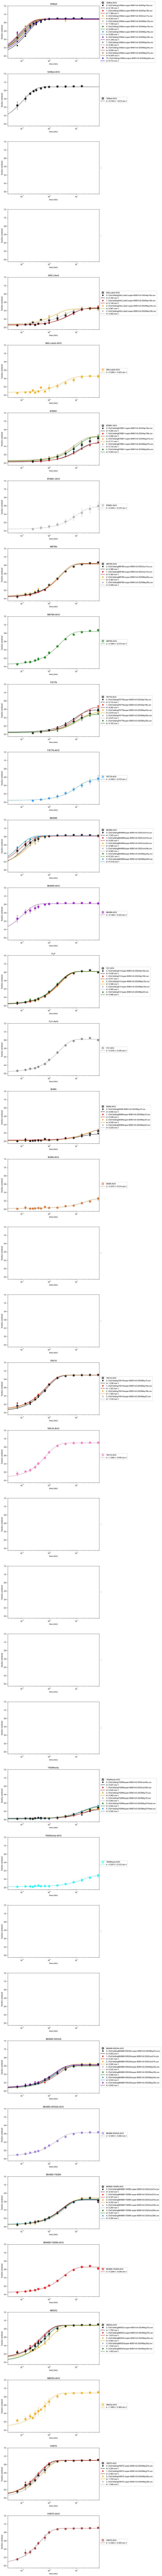

In [40]:
### testing plot_datafolders(inputdict,dictfolderlist,workingname,parameterdict={}):
plotthisfolder=list(range(11,12))
#[1,2,3]
plotthisfolder=[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]
#plotthisfolder=[11]
passplotparam={}
passplotparam["xlabel"]='time (min)'
passplotparam["ylabel"]='fraction centered'
passplotparam["xlim"]=[0.03, 70]
passplotparam["ylim"]=[-0.05, 1.2]
passplotparam["legend_loc"]='center left'
passplotparam["legend_bbox_to_anchor"]=(1, 0.5)
passplotparam["fitxvalues"]=np.arange(0.01,70,0.01)
workingname=outputdirectory+"sliding-chd1variants-on80N0-"
plot_datafolders_all(masterdictionary,plotthisfolder,workingname,passplotparam)

#plot_datafolders_indiv_single_plusresiduals(inputdict,dictfolder,exptdata,listname,listkeys,workingname,parameterdict={}):
#NEW def plot_datafolders_indiv_single_plusresiduals(inputdict,dictfolder,exptdata,ampkeylist,workingname):


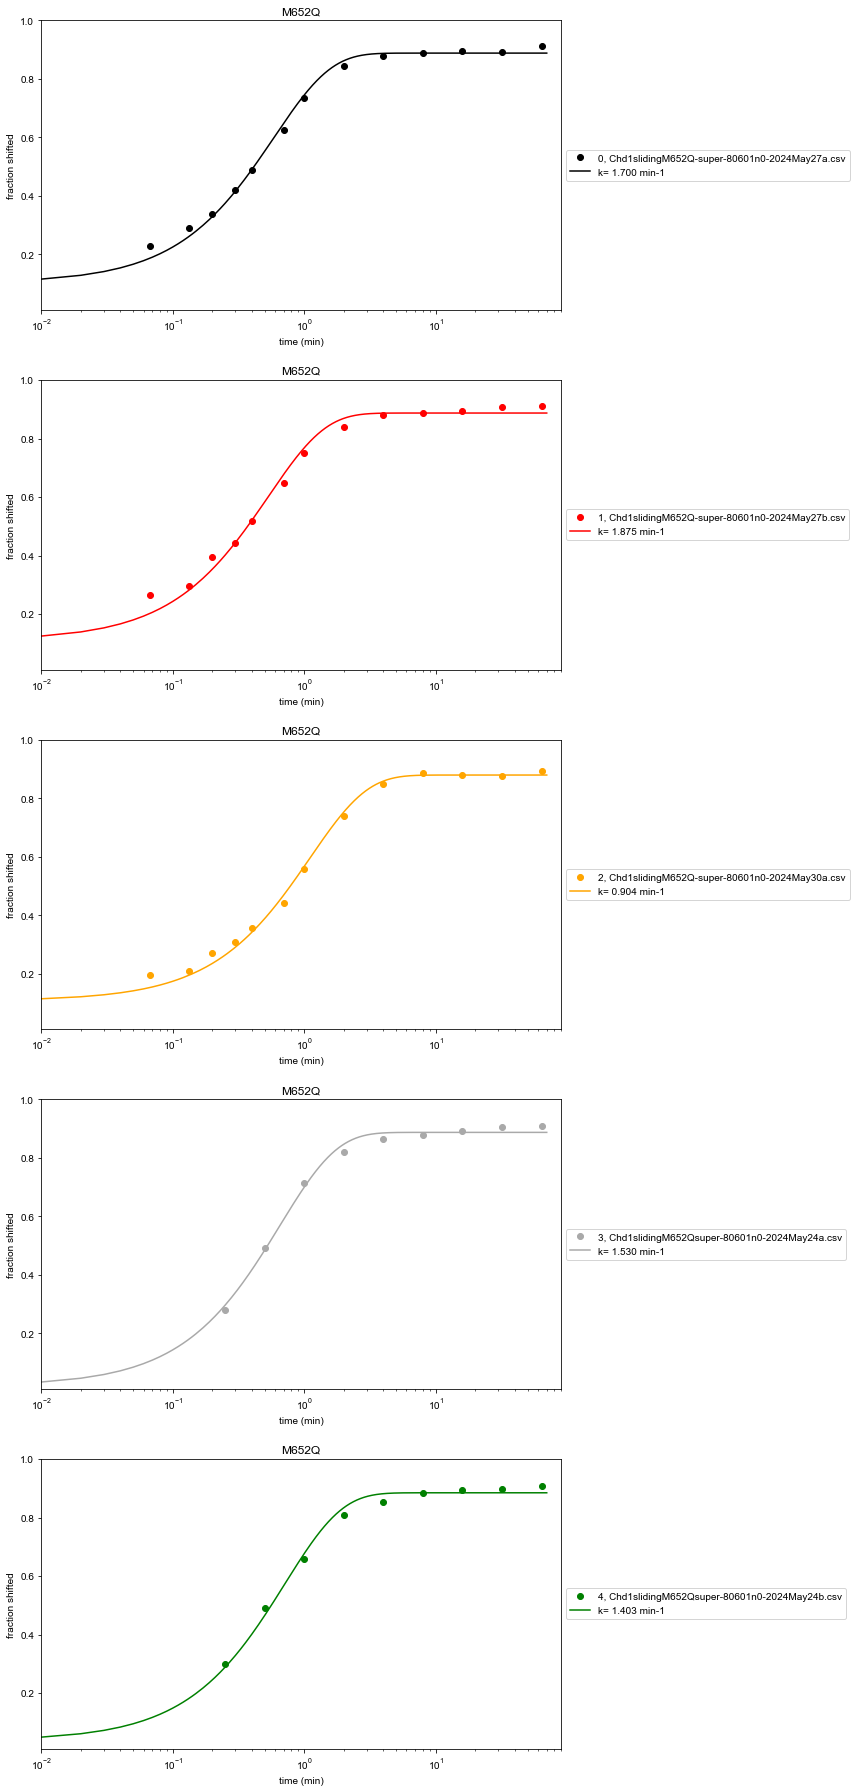

In [21]:
plotthesefolders=[18]

passplotparam={}
passplotparam["xlabel"]='time (min)'
passplotparam["ylabel"]='fraction shifted'
passplotparam["xlim"]=[0.01, 90]
passplotparam["ylim"]=[0.01, 1.0]
passplotparam["legend_loc"]='center left'
passplotparam["legend_bbox_to_anchor"]=(1, 0.5)
passplotparam["fitxvalues"]=np.arange(0.01,70,0.01)
workingname=outputdirectory+"sliding-M652Q-indiv-"
plot_datafolders_indiv_separate(masterdictionary,plotthesefolders,workingname,passplotparam)

# create output CSV file

In [56]:
print(dirkeyindices)
dirkeyindices_temp = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,18,19,20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [57]:
workingname="calcslidingrates-"+gettimestamp()+".csv"
myfile=open(outputdirectory+workingname,"w")

### header with basic info
myfile.write("this output file:"+","+workingname+"\n")

myfile.write("date/time,"+gettimestamp()+"\n")

myfile.write("\n")

for folder in dirkeyindices:
    if ("dirname" in masterdictionary[folder]):
        myfile.write("data directory,"+masterdictionary[folder]["dirname"]+"\n")
    if ("dataname" in masterdictionary[folder]):
        myfile.write("data name,"+masterdictionary[folder]["dataname"]+"\n")
    if ("fittingmodel" in masterdictionary[folder]):
        myfile.write("fitting model,"+masterdictionary[folder]["fittingmodel"]+"\n")
    if ("notes1" in masterdictionary[folder]): 
        myfile.write("notes,"+masterdictionary[folder]["notes1"]+"\n")
    myfile.write("\n")
    if (masterdictionary[folder]["fittingmodel"]=="1site"):
        myfile.write("index,filename,Kd \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},{:7.4f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0]))
            
        myfile.write(",AVG [stdev],{:7.4f},{:7.4f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0]))    
    elif (masterdictionary[folder]["fittingmodel"]=="calcKddouble"):
        myfile.write("index,filename,Kd1,,,Kd2 \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},{:7.4f},,,{:7.4f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1]))
        myfile.write(",AVG [stdev],{:7.4f},{:7.4f},,{:7.4f},{:7.4f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1]))  
    elif (masterdictionary[folder]["fittingmodel"]=="calcKddoubleAmp"):
        myfile.write("index,filename,Kd1,,,Kd2,,,Amplitude \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},{:7.4f},,,{:7.4f},,,{:7.4f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1],masterdictionary[folder][expt]["fit"][2]))
        myfile.write(",AVG [stdev],{:7.4f},{:7.4f},,{:7.4f},{:7.4f},,{:7.4f},{:7.4f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1],masterdictionary[folder]["fitAVG"][2],masterdictionary[folder]["fitSTDEV"][2]))  
    elif (masterdictionary[folder]["fittingmodel"]=="calcKddoubleAmpFixed"):
        myfile.write("index,filename,Kd1,,,Kd2,,,Amplitude \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},{:7.4f},,,{:7.4f},,,{:7.4f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1],masterdictionary[folder][expt]["fit"][2]))
        myfile.write(",AVG [stdev],{:7.4f},{:7.4f},,{:7.4f},{:7.4f},,{:7.4f},{:7.4f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1],masterdictionary[folder]["fitAVG"][2],masterdictionary[folder]["fitSTDEV"][2]))  
    elif (masterdictionary[folder]["fittingmodel"]=="fitsingleexprise"):
        myfile.write("index,filename,k,,,Amp,,,c \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            if 'fit' in masterdictionary[folder][expt]:
                myfile.write("{},{},{:7.4f},,,{:7.4f},,,{:7.4f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1],masterdictionary[folder][expt]["fit"][2]))
            else:
                myfile.write("{},{},{},,,{},,,{}\n".format(expt,masterdictionary[folder][expt]["filename"],"FAIL","FAIL","FAIL"))
        if "fitAVG" in masterdictionary[folder]:
            myfile.write(",AVG [stdev],{:7.4f},{:7.4f},,{:7.4f},{:7.4f},,{:7.4f},{:7.4f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1],masterdictionary[folder]["fitAVG"][2],masterdictionary[folder]["fitSTDEV"][2]))  
        else:
            myfile.write(",no AVG calc\n")
    elif (masterdictionary[folder]["fittingmodel"]=="fitdoubleexprise"):
        myfile.write("index,filename,k1,,,Amp1,,,k2,,,Amp2,,,c \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            if 'fit' in masterdictionary[folder][expt]:
                k1 = masterdictionary[folder][expt]["fit"][0]
                Amp1 = masterdictionary[folder][expt]["fit"][1]
                k2 = masterdictionary[folder][expt]["fit"][2]
                Amp2 = masterdictionary[folder][expt]["fit"][3]
                c = masterdictionary[folder][expt]["fit"][4]
                myfile.write("{},{},{:7.4f},,,{:7.4f},,,{:7.4f},,,{:7.4f},,,{:7.4f}\n".format(expt,masterdictionary[folder][expt]["filename"],k1,Amp1,k2,Amp2,c))
            else:
                myfile.write("{},{},{},,,{},,,{}\n".format(expt,masterdictionary[folder][expt]["filename"],"FAIL","FAIL","FAIL"))
        if "fitAVG" in masterdictionary[folder]:
            myfile.write(",AVG [stdev],{:7.4f},{:7.4f},,{:7.4f},{:7.4f},,{:7.4f},{:7.4f},,{:7.4f},{:7.4f},,{:7.4f},{:7.4f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],\
                                                                                                                                    masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1],\
                                                                                                                                    masterdictionary[folder]["fitAVG"][2],masterdictionary[folder]["fitSTDEV"][2],\
                                                                                                                                    masterdictionary[folder]["fitAVG"][3],masterdictionary[folder]["fitSTDEV"][3],\
                                                                                                                                     masterdictionary[folder]["fitAVG"][4],masterdictionary[folder]["fitSTDEV"][4]))  
        else:
            myfile.write(",no AVG calc\n")
    elif (masterdictionary[folder]["fittingmodel"]=="fitlinear"):
        myfile.write("index,filename,slope,,,intercept\n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            if 'fit' in masterdictionary[folder][expt]:
                myfile.write("{},{},{:7.5f},,,{:7.5f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1]))
            else:
                myfile.write("{},{},{},,,{}\n".format(expt,masterdictionary[folder][expt]["filename"],"FAIL","FAIL"))
        if "fitAVG" in masterdictionary[folder]:
            myfile.write(",AVG [stdev],{:7.5f},{:7.5f},,{:7.5f},{:7.5f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1]))  
        else:
            myfile.write(",no AVG calc\n")
    elif (masterdictionary[folder]["fittingmodel"]=="skip"):
        myfile.write("index,filename \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},skipped\n".format(expt,masterdictionary[folder][expt]["filename"]))

    myfile.write(",\n")    


myfile.close()

### change colors for averages

In [60]:
for folder in masterdictionary["dirkeys"]:
    masterdictionary[folder]["color2"]="black"
    if "120Bwt" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="black"
        
    elif "876881-I843N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"

    elif "884889-W932A" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"

    elif "876881" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="forestgreen"

    elif "SAILLobe2" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"
    elif "M876N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="forestgreen"
    elif "F877N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="forestgreen"
    elif "SAIL" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="lawngreen"            
    elif "L865N-L869N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="lawngreen"
    elif "884889" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"
    elif "FLF" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dodgerblue"
    elif "Y926" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dodgerblue"
    elif "Y841" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
    elif "A842N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
    elif "I843N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
    elif "W932Aonly" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dodgerblue"
    elif "I838N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
    elif "I583N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="gray"
    elif "M652Q" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
    elif "H587D" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="gray"


In [61]:
### set markers

for folder in masterdictionary["dirkeys"]:

    masterdictionary[folder]["m1"]="o"
    masterdictionary[folder]["m2"]="o"
    masterdictionary[folder]["markersize"] = 9
    ### star marker for point mutants
    if (("L865NL869N" in masterdictionary[folder]["dataname"]) or 
            ("L886NL889NL891N" in masterdictionary[folder]["dataname"]) or
            ("901insertion902" in masterdictionary[folder]["dataname"]) or            
            ("W932A" in masterdictionary[folder]["dataname"]) or
            ("901insertion902" in masterdictionary[folder]["dataname"]) or
            ("F917NL918NF921N" in masterdictionary[folder]["dataname"])):          
        masterdictionary[folder]["m1"]="*"
        masterdictionary[folder]["m2"]="*"
        masterdictionary[folder]["markersize"] = 13

    ### BigX marker for point mutants
    #if (("W932A" in masterdictionary[folder]["dataname"]) or
    #        ("M652Q" in masterdictionary[folder]["dataname"])):
    #    masterdictionary[folder]["m1"]="X"

    if "SAIL" in masterdictionary[folder]["dataname"]:
        ### down triangle
        masterdictionary[folder]["m1"]="v"
        masterdictionary[folder]["m2"]="v"
        masterdictionary[folder]["markersize"] = 11
    if "L865N-L869N" in masterdictionary[folder]["dataname"]:
        ### circle
        masterdictionary[folder]["m1"]="o"
        masterdictionary[folder]["m2"]="o"
        masterdictionary[folder]["markersize"] = 9

    if "M876" in masterdictionary[folder]["dataname"]:
        ### square
        masterdictionary[folder]["m1"]="s"
        masterdictionary[folder]["m2"]="s"
    if "F877" in masterdictionary[folder]["dataname"]:
        ### triangle
        masterdictionary[folder]["m1"]="^"
        masterdictionary[folder]["m2"]="^"
        masterdictionary[folder]["markersize"] = 11
    if "Y841" in masterdictionary[folder]["dataname"]:
        ### diamond
        masterdictionary[folder]["m1"]="D"
        masterdictionary[folder]["m2"]="D"
        masterdictionary[folder]["markersize"] = 9
    if "A842N" in masterdictionary[folder]["dataname"]:
        ### square
        masterdictionary[folder]["m1"]="s"
        masterdictionary[folder]["m2"]="s"
    if "I843N" in masterdictionary[folder]["dataname"]:
        ### triangle
        masterdictionary[folder]["m1"]="^"
        masterdictionary[folder]["m2"]="^"
        masterdictionary[folder]["markersize"] = 11
    if "I838N" in masterdictionary[folder]["dataname"]:
        ### down triangle
        masterdictionary[folder]["m1"]="v"
        masterdictionary[folder]["m2"]="v"
        masterdictionary[folder]["markersize"] = 11

    if "583" in masterdictionary[folder]["dataname"]:
        ### square
        masterdictionary[folder]["m1"]="s"
        masterdictionary[folder]["m2"]="s"
    if "587" in masterdictionary[folder]["dataname"]:
        ### diamond
        masterdictionary[folder]["m1"]="d"
        masterdictionary[folder]["m2"]="d"
        masterdictionary[folder]["markersize"] = 10
    if "926" in masterdictionary[folder]["dataname"]:
        ### triangle
        masterdictionary[folder]["m1"]="p"
        masterdictionary[folder]["m2"]="p"
        masterdictionary[folder]["markersize"] = 10
    if "M652Q" in masterdictionary[folder]["dataname"]:
        ### triangle
        masterdictionary[folder]["m1"]="X"
        masterdictionary[folder]["m2"]="X"
        masterdictionary[folder]["markersize"] = 10    


In [62]:
#print(masterdictionary[i]["dataname"])
print()
print("Here are the folders loaded in")
print()
for i in masterdictionary["dirkeys"]:
    print(i,masterdictionary[i]["dataname"])
    print()



Here are the folders loaded in

0 120Bwt

1 SAIL

2 SAILLobe2

3 876881

4 M876N

5 F877N

6 884889

7 FLF

8 I583N

9 I838N

10 A842N

11 Y841A

12 I843Nonly

13 884889-I843N

14 Y926Nonly

15 W932Aonly

16 884889-W932A

17 884889-Y926N

18 M652Q

19 H587D

20 L865N-L869N



In [63]:
### add fake fits where the exponential and linear fits failed to match data
for i in masterdictionary["dirkeys"]:
    if "SAILLobe2" in masterdictionary[i]['dataname']:
        masterdictionary[i]['fitAVG_fake'] = [0.22,0.40,0.001,0,-0.55] 
    elif "SAIL" in masterdictionary[i]['dataname']: #0.5,0.08,0.021,0.2,-0.65 #0.08,0.15,0.005,0.3,-0.47
        masterdictionary[i]['fitAVG_fake'] = [0.5,0.08,0.021,0.2,-0.65]

## Plot data on one graph (for Figure 1)

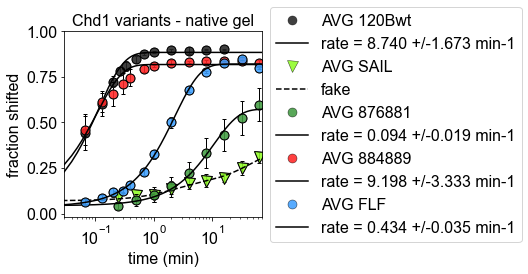

In [28]:
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 16, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (7.5,4),'errorbar.capsize': 2})

fitxvalues=np.arange(0.01,75,0.01)

plotthese=[0,1,3,6,7]

#for i in dirkeyindices:
for i in plotthese:
    #error bars
    plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],lw=1,linestyle='None',color="black")

    #white transparent background
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],color="white",linestyle='None',alpha=0.5,markersize=masterdictionary[i]["markersize"])
    # colored symbol
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m1"], mec="black",mew=0.5,linestyle='None',label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=0.75,markersize=masterdictionary[i]["markersize"])
    #black outline
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],mec="black", mew=1, linestyle='None',fillstyle='none',alpha=1,markersize=masterdictionary[i]["markersize"])
    # colored line fit
    if 'fitAVG_fake' in masterdictionary[i]:
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG_fake"]), '--', label="fake",color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitsingleexprise':
        plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitdoubleexprise':
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitlinear':
        plt.plot(fitxvalues, fitlinear(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")

### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([0.03, 70])
plt.ylim([-0.02, 1])
plt.legend()
plt.xlabel('time (min)'); 
plt.ylabel('fraction shifted'); 

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
plt.title("Chd1 variants - native gel", fontsize=16)
legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   

#add time stamp to filename
workingname=outputdirectory+"nativesliding-80601n0-origvariants-AVG-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')


## Plot data on one graph (for Suppl Figure)

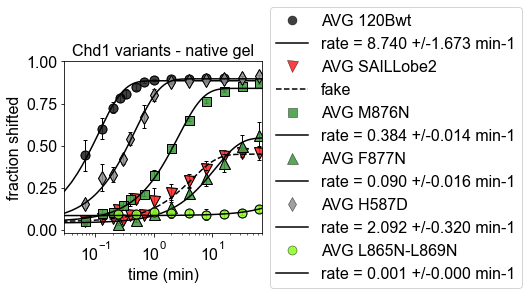

In [64]:
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 16, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (7.5,4),'errorbar.capsize': 2})

fitxvalues=np.arange(0.01,75,0.01)

plotthese=[0,2,4,5,19,20]

#for i in dirkeyindices:
for i in plotthese:
    #error bars
    plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],lw=1,linestyle='None',color="black")

    #white transparent background
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],color="white",linestyle='None',alpha=0.5,markersize=masterdictionary[i]["markersize"])
    # colored symbol
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m1"], mec="black",mew=0.5,linestyle='None',label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=0.75,markersize=masterdictionary[i]["markersize"])
    #black outline
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],mec="black", mew=1, linestyle='None',fillstyle='none',alpha=1,markersize=masterdictionary[i]["markersize"])
    # colored line fit
    if 'fitAVG_fake' in masterdictionary[i]:
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG_fake"]), '--', label="fake",color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitsingleexprise':
        plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitdoubleexprise':
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitlinear':
        plt.plot(fitxvalues, fitlinear(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
        
### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([0.03, 70])
plt.ylim([-0.02, 1])
plt.legend()
plt.xlabel('time (min)'); 
plt.ylabel('fraction shifted'); 

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
plt.title("Chd1 variants - native gel", fontsize=16)
legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   

#add time stamp to filename
workingname=outputdirectory+"nativesliding-80601n0-origvariants-AVG-forSuppl-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')


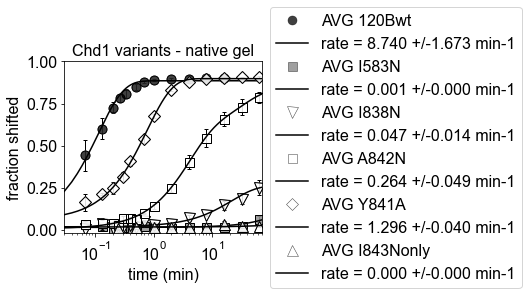

In [65]:
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 16, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (7.5,4),'errorbar.capsize': 2})

fitxvalues=np.arange(0.01,75,0.01)

#fig, axs = plt.subplots(2*len(masterdictionary), 1)
###AMPPNP all
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]
###AMPPNP deletions only
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]

plotthese=[0,8,9,10,11,12]

#for i in dirkeyindices:
for i in plotthese:
    #error bars
    plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],lw=1,linestyle='None',color="black")

    #white transparent background
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],color="white",linestyle='None',alpha=0.5,markersize=masterdictionary[i]["markersize"])
    # colored symbol
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m1"], mec="black",mew=0.5,linestyle='None',label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=0.75,markersize=masterdictionary[i]["markersize"])
    #black outline
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],mec="black", mew=1, linestyle='None',fillstyle='none',alpha=1,markersize=masterdictionary[i]["markersize"])
    # colored line fit
    if 'fitAVG_fake' in masterdictionary[i]:
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG_fake"]), '--', label="fake",color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitsingleexprise':
        plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitdoubleexprise':
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitlinear':
        plt.plot(fitxvalues, fitlinear(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
        
### test linear
#plt.plot(fitxvalues,fitlinear(fitxvalues, *[0.05,0.05]),'--',label="testlinear",color="black")
### test fake exp rise
#plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *[0.22,0.40,-0.55]), '--', label="fake1exp",color="red")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.22,0.40,0.001,0,-0.55]), '--', label="fake1exp",color="orange")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.5,0.08,0.021,0.2,-0.65]), '--', label="fake2exp",color="forestgreen")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.07,0.05,0.045,0.28,-0.66]), '--', label="fake2exp",color="lawngreen")
#plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *[0.01,0.05,-0.94]), '--', label="fake2exp",color="red")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.01,0.05,0.002,0.2,-0.74]), '--', label="fake2exp",color="red")
#plt.plot(fitxvalues, fitlinear(fitxvalues, *[0.0008,0.01]), '--', label="fakelinear",color="magenta")


### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([0.03, 70])
plt.ylim([-0.02, 1])
plt.legend()
plt.xlabel('time (min)'); 
plt.ylabel('fraction shifted'); 

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
plt.title("Chd1 variants - native gel", fontsize=16)
legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   
#fig.tight_layout(h_pad=2)

#add time stamp to filename
workingname=outputdirectory+"80601n0-braceIvariants-nativesliding-AVG-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')


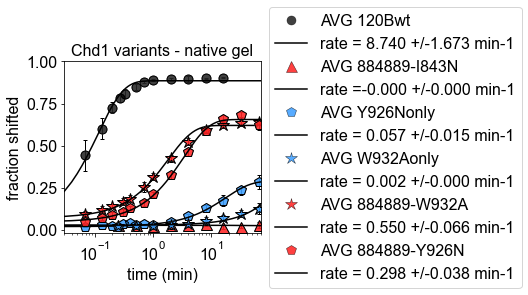

In [66]:
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 16, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (7.5,4),'errorbar.capsize': 2})

fitxvalues=np.arange(0.01,75,0.01)

#fig, axs = plt.subplots(2*len(masterdictionary), 1)
###AMPPNP all
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]
###AMPPNP deletions only
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]

plotthese=[0,13,14,15,16,17]

#for i in dirkeyindices:
for i in plotthese:
    #error bars
    plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],lw=1,linestyle='None',color="black")

    #white transparent background
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],color="white",linestyle='None',alpha=0.5,markersize=masterdictionary[i]["markersize"])
    # colored symbol
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m1"], mec="black",mew=0.5,linestyle='None',label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=0.75,markersize=masterdictionary[i]["markersize"])
    #black outline
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],mec="black", mew=1, linestyle='None',fillstyle='none',alpha=1,markersize=masterdictionary[i]["markersize"])
    # colored line fit
    if 'fitAVG_fake' in masterdictionary[i]:
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG_fake"]), '--', label="fake",color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitsingleexprise':
        plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitdoubleexprise':
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitlinear':
        plt.plot(fitxvalues, fitlinear(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
        
### test linear
#plt.plot(fitxvalues,fitlinear(fitxvalues, *[0.05,0.05]),'--',label="testlinear",color="black")
### test fake exp rise
#plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *[0.22,0.40,-0.55]), '--', label="fake1exp",color="red")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.22,0.40,0.001,0,-0.55]), '--', label="fake1exp",color="orange")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.5,0.08,0.021,0.2,-0.65]), '--', label="fake2exp",color="forestgreen")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.07,0.05,0.045,0.28,-0.66]), '--', label="fake2exp",color="lawngreen")
#plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *[0.01,0.05,-0.94]), '--', label="fake2exp",color="red")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.01,0.05,0.002,0.2,-0.74]), '--', label="fake2exp",color="red")
#plt.plot(fitxvalues, fitlinear(fitxvalues, *[0.0008,0.01]), '--', label="fakelinear",color="magenta")


### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([0.03, 70])
plt.ylim([-0.02, 1])
plt.legend()
plt.xlabel('time (min)'); 
plt.ylabel('fraction shifted'); 

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
plt.title("Chd1 variants - native gel", fontsize=16)
legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   
#fig.tight_layout(h_pad=2)

#add time stamp to filename
workingname=outputdirectory+"80601n0-NegCrecovery-nativesliding-AVG-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')


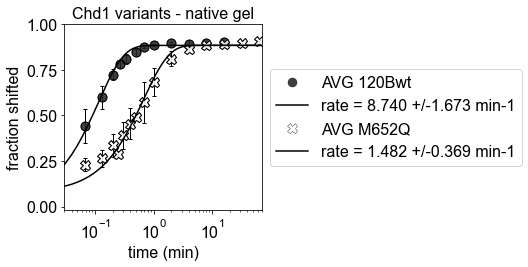

In [67]:
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 16, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (7.5,4),'errorbar.capsize': 2})

fitxvalues=np.arange(0.01,75,0.01)

#fig, axs = plt.subplots(2*len(masterdictionary), 1)
###AMPPNP all
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]
###AMPPNP deletions only
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]

plotthese=[0,18]

#for i in dirkeyindices:
for i in plotthese:
    #error bars
    plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],lw=1,linestyle='None',color="black")

    #white transparent background
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],color="white",linestyle='None',alpha=0.5,markersize=masterdictionary[i]["markersize"])
    # colored symbol
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m1"], mec="black",mew=0.5,linestyle='None',label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=0.75,markersize=masterdictionary[i]["markersize"])
    #black outline
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],mec="black", mew=1, linestyle='None',fillstyle='none',alpha=1,markersize=masterdictionary[i]["markersize"])
    # colored line fit
    if 'fitAVG_fake' in masterdictionary[i]:
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG_fake"]), '--', label="fake",color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitsingleexprise':
        plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitdoubleexprise':
        plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
    elif masterdictionary[i]['fittingmodel'] == 'fitlinear':
        plt.plot(fitxvalues, fitlinear(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="rate ={:6.3f} +/-{:5.3f} min-1".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitSTDEV"][0]),color="black")
        
### test linear
#plt.plot(fitxvalues,fitlinear(fitxvalues, *[0.05,0.05]),'--',label="testlinear",color="black")
### test fake exp rise
#plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *[0.22,0.40,-0.55]), '--', label="fake1exp",color="red")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.22,0.40,0.001,0,-0.55]), '--', label="fake1exp",color="orange")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.5,0.08,0.021,0.2,-0.65]), '--', label="fake2exp",color="forestgreen")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.07,0.05,0.045,0.28,-0.66]), '--', label="fake2exp",color="lawngreen")
#plt.plot(fitxvalues, fitsingleexprise(fitxvalues, *[0.01,0.05,-0.94]), '--', label="fake2exp",color="red")
#plt.plot(fitxvalues, fitdoubleexprise(fitxvalues, *[0.01,0.05,0.002,0.2,-0.74]), '--', label="fake2exp",color="red")
#plt.plot(fitxvalues, fitlinear(fitxvalues, *[0.0008,0.01]), '--', label="fakelinear",color="magenta")


### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([0.03, 70])
plt.ylim([-0.02, 1])
plt.legend()
plt.xlabel('time (min)'); 
plt.ylabel('fraction shifted'); 

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
plt.title("Chd1 variants - native gel", fontsize=16)
legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   
#fig.tight_layout(h_pad=2)

#add time stamp to filename
workingname=outputdirectory+"80601n0-M652-nativesliding-AVG-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')
